In [ ]:
using Knet

In [117]:
using Images, ImageView, Colors

In [118]:
using Plots

In [ ]:
include("../src/loadnoisey2D.jl")
include("../src/models.jl")

In [ ]:
function up!(w,dw,lr = 0.1,proj! = nothing)
    for i in 1:length(w)
        # dw[i] == nothing represents w[i] not being used 
        # during forward pass recording of gradient.
        # Therefore, dw[i] is not assigned and equals nothing
        if dw[i] ≠ nothing
            w[i] -= lr * dw[i]
        end
    end
    if proj! ≠ nothing
        proj!(w)
    end
end

In [ ]:
function linesearch!(w,x,y,lr=0.1,s=1.5,maxiter=100,proj! = nothing)
    dw, loss0 = gradlossgradient(w,x,y)
    
    if s <= 1.0
        up!(w,dw,lr,proj!)
        return lr
    end
    
    #up!(w,dw,lr,proj!)
    wtest = copy(w)
    up!(wtest,dw,lr,proj!)
    loss1 = loss(wtest,x,y)
    
    isdescent = false
    if loss1 < loss0
        lr *= s
        isdescent = true
    else
        it = 0
        while true
            it += 1
            lr /= s
            
            #up!(w,dw,lr*(one(s)-s),proj!)
            #loss1 = loss(w,x,y)
            copy!(wtest,w)
            up!(wtest,dw,lr,proj!)
            loss1 = loss(wtest,x,y)
            
            isdescent = (loss1 < loss0) # || isnan(loss1) || isinf(loss1)
            (isdescent || it >= maxiter) && break
        end
    end
    
    #if !isdescent
    #    up!(w,dw,lr*(s-one(s)),proj!)
    #end
    if isdescent
        copy!(w,wtest)
#         println("loss1  < loss0: $isdescent, $(loss1<loss0)")
#         loss2 = loss(w,x,y)
#         println("loss2 == loss1: $(loss2==loss1)")
#         println("loss1: $(loss2)")
#         println("loss2: $(loss2)")
    end
    
    return lr
end

In [101]:
# SGD training loop
function train_sgd!(w, data; lr=.1, s=-1.0, maxiter = 100, proj! = nothing)
    for (x,y) in data
#         loss0 = loss(w,x,y)
        lr = linesearch!(w,x,y,lr,s,maxiter,proj!)
#         loss1 = loss(w,x,y)
#         println(loss1<loss0)
    end
    return lr
end

train_sgd! (generic function with 1 method)

In [102]:
# define misc. params
seed  = 42
Ftype = Float32
# Atype = Array{Ftype}
Atype = KnetArray{Ftype}
atype = Atype
srand(seed);

In [103]:
bs = 5 # batch size
ep = 10 # epochs
maxiter = 100 # max iters for linesearch

100

In [104]:
xtrn,ytrn,xtst,ytst = chi2d(atype=atype)
imdims = (size(xtrn,1),size(xtrn,2))
dtrn = minibatch(xtrn, ytrn, bs, xtype=atype, ytype=atype)
dtst = minibatch(xtst, ytst, bs, xtype=atype, ytype=atype);
#prms = params(w, o)

### Simple convolution model

In [141]:
const sk = 7 # size of convolution kernel
const bsiz = (1,1) # size of bias array

p = params_simpleconv(atype=atype,seed=seed,sk=sk,bsiz=bsiz)
weights() = weights_simpleconv(p)
predict(w,x) = predict_simpleconv(w,x,p)
#proj!(w) = project_simpleconv!(w,p)
proj! = nothing
loss(w,x,y) = loss_simpleconv(w,x,y,p)
lossgradient = grad(loss)
gradlossgradient = gradloss(loss)
#accuracy(w,data,predict) = sum(map(d->loss(w,d[1],d[2]),data))

(::gradfun) (generic function with 1 method)

### LeNet model

In [10]:
const kernsize = 5 # size of convolution kernel
const nconv = 4 # number of convolutional layers
const nfull = 1 # number of fully connected layers
nc = [5,10,20,50] # number of feature kernels per layer
nf = [500] # fully connected sizes

p = params_lenet(atype=atype,seed=seed,imdims=imdims,
    kernsize=kernsize,nconv=nconv,nfull=nfull,nc=nc,nf=nf)
weights() = weights_lenet(p)
predict(w,x) = predict_lenet(w,x,p)
proj!(w) = project_lenet!(w,p)
loss(w,x,y) = loss_lenet(w,x,y,p)
lossgradient = grad(loss)
gradlossgradient = gradloss(loss)
#accuracy(w,data,predict) = sum(map(d->loss(w,d[1],d[2]),data))

(::gradfun) (generic function with 1 method)

### kobler model

In [113]:
const T  = 5 # number of "time steps" for xₜ
const C  = 5 # number of fc terms
const Nr = 3 # number of regularization terms in each fc
const Nd = 3 # number of data fidelity terms in each fc
const Nw = 7 # number of radial basis functions in each influence function
const sr = 5 # size of kernel for regularization term convolutions is [sr×sr]
const sd = 5 # size of kernel for data fidelity term convolutions is [sr×sr]
const prj = true # project initial data on unit norm kernels with zero mean
cycle = "cyclic" # access pattern function c(t)

p = params_kobler(atype=atype,seed=seed,cycle=cycle,C=C,T=T,Nr=Nr,Nd=Nd,Nw=Nw,sr=sr,sd=sd,proj=prj)
weights() = weights_kobler(p)
predict(w,x) = predict_kobler(w,x,p)
loss(w,x,y) = loss_kobler(w,x,y,p)
proj!(w) = project_kobler!(w,p)
#proj! = nothing
lossgradient = grad(loss)
gradlossgradient = gradloss(loss)
#accuracy(w,data,predict) = sum(map(d->loss(w,d[1],d[2]),data))

(::gradfun) (generic function with 1 method)

In [114]:
# initial weights and loss
lr = Ftype(1e-3) # learning rate
s  = Ftype(1.5) # line search parameter
w  = weights()
ws = [copy(w)]
losses = [loss(w,xtrn,ytrn)]

1-element Array{Float32,1}:
 128.844

In [115]:
# println(norm(vec(Array(w[2+2C+1])[:,:,1,1])))
# println(mean(vec(Array(w[2+2C+2])[:,:,1,3])))
# map(size,w);

In [116]:
# Record the weights and losses for `ep` epochs
@time for epoch in 1:1000
    #@time lr = train_sgd!(w,dtrn,lr=lr,s=s,proj! = proj!)
    lr = train_sgd!(w,dtrn,lr=lr,s=s,proj! = proj!)
    #push!(ws, copy(w))
    push!(losses, loss(w,xtrn,ytrn))
    #println("epoch = $epoch, lr = $lr, loss = $(losses[end])")
    if (ep < 1000) || mod1(epoch,1000)==1
        println("epoch = $epoch, lr = $lr, loss = $(losses[end])")
    end
end

epoch = 1, lr = 0.00029629632, loss = 119.429955
epoch = 2, lr = 0.00019753088, loss = 82.09819
epoch = 3, lr = 0.00029629632, loss = 36.790108
epoch = 4, lr = 0.00019753088, loss = 30.641485
epoch = 5, lr = 0.00029629632, loss = 28.012278
epoch = 6, lr = 0.00044444448, loss = 27.884314
epoch = 7, lr = 0.00019753088, loss = 26.063593
epoch = 8, lr = 0.00029629632, loss = 25.15981
epoch = 9, lr = 0.00044444448, loss = 24.70135
epoch = 10, lr = 0.00029629632, loss = 24.511444
epoch = 11, lr = 0.00019753088, loss = 23.643604
epoch = 12, lr = 0.00029629632, loss = 23.182522
epoch = 13, lr = 0.00044444448, loss = 22.841908
epoch = 14, lr = 0.00029629632, loss = 22.595722
epoch = 15, lr = 0.00044444448, loss = 22.46841
epoch = 16, lr = 0.00019753088, loss = 21.957752
epoch = 17, lr = 0.00029629632, loss = 21.671251
epoch = 18, lr = 0.00044444448, loss = 21.440536
epoch = 19, lr = 0.00029629632, loss = 21.253407
epoch = 20, lr = 0.00044444448, loss = 21.124596
epoch = 21, lr = 0.00029629632, 

epoch = 168, lr = 0.00019753087, loss = 13.441028
epoch = 169, lr = 0.00029629632, loss = 13.427991
epoch = 170, lr = 0.00019753088, loss = 13.416815
epoch = 171, lr = 0.00029629632, loss = 13.4088955
epoch = 172, lr = 0.00019753088, loss = 13.40671
epoch = 173, lr = 0.00013168725, loss = 13.377048
epoch = 174, lr = 0.00019753087, loss = 13.361044
epoch = 175, lr = 0.00029629632, loss = 13.348679
epoch = 176, lr = 0.00019753088, loss = 13.33826
epoch = 177, lr = 0.00029629632, loss = 13.331305
epoch = 178, lr = 0.00019753088, loss = 13.330559
epoch = 179, lr = 0.00013168725, loss = 13.300641
epoch = 180, lr = 0.00019753087, loss = 13.284665
epoch = 181, lr = 0.00029629632, loss = 13.273191
epoch = 182, lr = 0.00019753088, loss = 13.263975
epoch = 183, lr = 0.00029629632, loss = 13.258855
epoch = 184, lr = 0.00013168725, loss = 13.236837
epoch = 185, lr = 0.00019753087, loss = 13.223538
epoch = 186, lr = 0.00029629632, loss = 13.21167
epoch = 187, lr = 0.00019753088, loss = 13.201395
ep

epoch = 333, lr = 0.00019753087, loss = 11.989831
epoch = 334, lr = 0.00029629632, loss = 11.984606
epoch = 335, lr = 0.00019753088, loss = 11.982135
epoch = 336, lr = 0.00013168725, loss = 11.972643
epoch = 337, lr = 0.00019753087, loss = 11.965681
epoch = 338, lr = 0.00029629632, loss = 11.96078
epoch = 339, lr = 0.00019753088, loss = 11.958967
epoch = 340, lr = 0.00013168725, loss = 11.949022
epoch = 341, lr = 0.00019753087, loss = 11.941873
epoch = 342, lr = 0.00029629632, loss = 11.937372
epoch = 343, lr = 0.00019753088, loss = 11.936396
epoch = 344, lr = 0.00013168725, loss = 11.925833
epoch = 345, lr = 0.00019753087, loss = 11.918417
epoch = 346, lr = 0.00029629632, loss = 11.914413
epoch = 347, lr = 0.00013168725, loss = 11.906824
epoch = 348, lr = 0.00019753087, loss = 11.900787
epoch = 349, lr = 0.00029629632, loss = 11.89532
epoch = 350, lr = 0.00019753088, loss = 11.891943
epoch = 351, lr = 0.00013168725, loss = 11.883923
epoch = 352, lr = 0.00019753087, loss = 11.877703
ep

epoch = 499, lr = 0.00019753087, loss = 11.183893
epoch = 500, lr = 0.00029629632, loss = 11.181892
epoch = 501, lr = 0.00013168725, loss = 11.176427
epoch = 502, lr = 0.00019753087, loss = 11.171949
epoch = 503, lr = 0.00029629632, loss = 11.169307
epoch = 504, lr = 0.00013168725, loss = 11.164355
epoch = 505, lr = 0.00019753087, loss = 11.160173
epoch = 506, lr = 0.00029629632, loss = 11.157046
epoch = 507, lr = 0.00019753088, loss = 11.156746
epoch = 508, lr = 0.00013168725, loss = 11.150131
epoch = 509, lr = 0.00019753087, loss = 11.145055
epoch = 510, lr = 0.00029629632, loss = 11.143778
epoch = 511, lr = 0.00013168725, loss = 11.137936
epoch = 512, lr = 0.00019753087, loss = 11.13327
epoch = 513, lr = 0.00029629632, loss = 11.131259
epoch = 514, lr = 0.00013168725, loss = 11.12599
epoch = 515, lr = 0.00019753087, loss = 11.121658
epoch = 516, lr = 0.00029629632, loss = 11.1190815
epoch = 517, lr = 0.00013168725, loss = 11.114272
epoch = 518, lr = 0.00019753087, loss = 11.1101885


epoch = 664, lr = 0.00013168725, loss = 10.621996
epoch = 665, lr = 0.00019753087, loss = 10.618333
epoch = 666, lr = 0.00029629632, loss = 10.617388
epoch = 667, lr = 0.00013168725, loss = 10.613027
epoch = 668, lr = 0.00019753087, loss = 10.6094
epoch = 669, lr = 0.00029629632, loss = 10.608401
epoch = 670, lr = 0.00013168725, loss = 10.604087
epoch = 671, lr = 0.00019753087, loss = 10.600504
epoch = 672, lr = 0.00029629632, loss = 10.599457
epoch = 673, lr = 0.00013168725, loss = 10.595207
epoch = 674, lr = 0.00019753087, loss = 10.591649
epoch = 675, lr = 0.00029629632, loss = 10.590569
epoch = 676, lr = 0.00013168725, loss = 10.586353
epoch = 677, lr = 0.00019753087, loss = 10.582834
epoch = 678, lr = 0.00029629632, loss = 10.58172
epoch = 679, lr = 0.00013168725, loss = 10.577557
epoch = 680, lr = 0.00019753087, loss = 10.574057
epoch = 681, lr = 0.00029629632, loss = 10.572926
epoch = 682, lr = 0.00013168725, loss = 10.568785
epoch = 683, lr = 0.00019753087, loss = 10.565317
epo

epoch = 829, lr = 0.00013168725, loss = 10.177687
epoch = 830, lr = 0.00019753087, loss = 10.175166
epoch = 831, lr = 0.00029629632, loss = 10.173266
epoch = 832, lr = 0.00013168725, loss = 10.170435
epoch = 833, lr = 0.00019753087, loss = 10.167883
epoch = 834, lr = 0.00029629632, loss = 10.166115
epoch = 835, lr = 0.00013168725, loss = 10.163223
epoch = 836, lr = 0.00019753087, loss = 10.160632
epoch = 837, lr = 0.00029629632, loss = 10.159015
epoch = 838, lr = 0.00013168725, loss = 10.156044
epoch = 839, lr = 0.00019753087, loss = 10.153413
epoch = 840, lr = 0.00029629632, loss = 10.15196
epoch = 841, lr = 0.00013168725, loss = 10.148912
epoch = 842, lr = 0.00019753087, loss = 10.146225
epoch = 843, lr = 0.00029629632, loss = 10.144961
epoch = 844, lr = 0.00013168725, loss = 10.141812
epoch = 845, lr = 0.00019753087, loss = 10.139073
epoch = 846, lr = 0.00029629632, loss = 10.138013
epoch = 847, lr = 0.00013168725, loss = 10.134764
epoch = 848, lr = 0.00019753087, loss = 10.131956
e

epoch = 995, lr = 0.00029629632, loss = 9.806337
epoch = 996, lr = 0.00013168725, loss = 9.803778
epoch = 997, lr = 0.00019753087, loss = 9.801499
epoch = 998, lr = 0.00029629632, loss = 9.800403
epoch = 999, lr = 0.00013168725, loss = 9.797724
epoch = 1000, lr = 0.00019753087, loss = 9.7953615
147.775390 seconds (63.06 M allocations: 2.392 GiB, 18.20% gc time)


In [119]:
#map(Array,w)
push!(ws,w)

2-element Array{Array{Any,1},1}:
 Any[Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800e57c00, 28, 0, nothing), (7, 1)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000840b15800, 4, 0, nothing), (1, 1)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800e8f000, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000840ad4e00, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000840b4cc00, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800dea600, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800e21400, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000840b72000, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800dd6800, 84, 0, nothing), (3, 7)), Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x0000000800e5d400, 84, 0, nothing), (3, 7))  …  

In [120]:
println(norm(vec(Array(ws[end][2+2C+1])[:,:,1,3])))
println(mean(vec(Array(ws[end][2+2C+2])[:,:,1,1])))
println(Array(ws[end][2]))

0.99999994
-3.5762786e-9
Float32[0.465078]


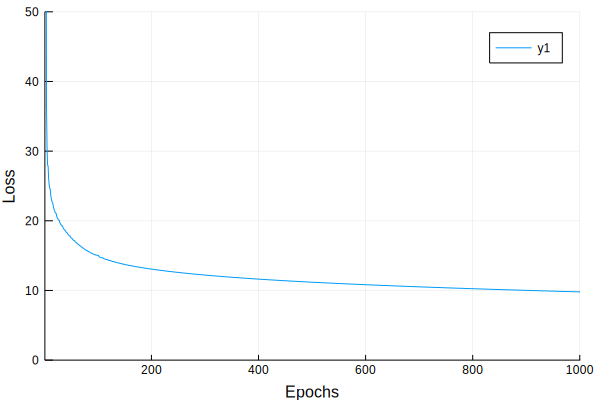

In [121]:
plot(losses,xlabel="Epochs",ylabel="Loss",ylim=(0.0,50.0)) 

In [122]:
idx = 5
# imshow(Array{Ftype}(w[1])[:,:,1,1]);
imshow(Array{Ftype}(w[end])[:,:,1,1]);
imshow(Array{Ftype}(xtrn)[:,:,1,idx]);
imshow(Array{Ftype}(predict(w,xtrn))[:,:,1,idx]);
imshow(Array{Ftype}(ytrn)[:,:,1,idx]);

### testing gradients

In [39]:
# Testing the gradient: Increasing w[2] (scalar μ) by eps_w should decrease loss by grad_w2 * eps_w2
h = Ftype(1e-1)
num_tests = 3
ldiff = zeros(num_tests,length(w))
vdot(x, y) = sum(vec(x).*vec(y))
for (x,y) in dtst
    println(typeof(x))
    println(typeof(y))
    for i in 1:num_tests
        println("    h: $h")
        for j in 1:length(w)
            w0 = copy(w)
            loss0 = loss(w0,x,y)
            grad0 = lossgradient(w0,x,y)
            eps_w = h * Atype(randn(Ftype,size(w0[j])))
            w0[j] -= eps_w
            loss1 = loss(w0,x,y)
            Δloss = loss1 - loss0
            Δgrad = -vdot(vec(grad0[j]), vec(eps_w))
            ldiff[i,j] = abs(Δloss - Δgrad)
            #println("Δloss[$i]: ", Δloss)
            #println("Δgrad[$i]: ", Δgrad)
        end
        println(" diff: ", ldiff[i,:])
        i > 1 && println("ratio: ", ldiff[i-1,:]./ldiff[i,:])
        h /= 2.0f0
    end
end

In [31]:
for (x,y) in dtst
    gradcheck(loss, w, x, y; verbose=true)
end

# Linear regression testing with imfilter

In [350]:
# define types
srand(42)
Ftype = Float64
Atype = Array{Ftype};

In [352]:
# Initialize model
m, n = 50, 60

xp, yp = linspace(-pi,pi,m), linspace(-pi,pi,n)'
Wx, Wy = 1:5, 1:5
idx = 1
y = zeros(m,n,1,length(Wx)*length(Wy))
for (ωx,ωy) in Iterators.product(Wx,Wy)
    y[:,:,1,idx] = Atype( sin.(ωx*xp) .* cos.(ωy*yp) );
    idx += 1
end
x = Atype(y + 0.5randn(Ftype,size(y)));
w = [ Atype(0.1*randn(5,5,1,1)), Ftype(1.0) ];

In [353]:
#z = imfilter(x,centered(w));
z = conv4(w[1],x,padding=1);

In [354]:
# Define loss
predict(w,x) = conv4(w[1],x,padding=div(size(w[1],1),2)) .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

In [355]:
w0 = w[2]
loss0 = loss(w,x,y)

1.2025514132303978

In [356]:
# Testing the gradient: Increasing w[2] by eps_w should decrease loss by 1.9996 * eps_w
grad0 = lossgradient(w,x,y)
eps_w = 0.0001
w[2] = w0 - eps_w
loss1 = loss(w,x,y);

In [357]:
loss1 - loss0

-0.0002000528670471624

In [358]:
-grad0[2] * eps_w

-0.00020006286704758562

In [359]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train! (generic function with 1 method)

In [366]:
# Record the weights for 10 epochs
@time weights = [ copy(train!(w, [(x, y)])) for epoch=1:10 ];
weights[end][1]

 24.838604 seconds (62.24 M allocations: 2.198 GiB, 25.63% gc time)


5×5×1×1 Array{Float64,4}:
[:, :, 1, 1] =
  0.0603571   0.0132552  0.063892   0.0274858   0.0322449
 -0.0333668   0.0864598  0.0876568  0.0515261   0.0370344
  0.0357426   0.0624823  0.0490681  0.055675    0.0754124
  0.0435113   0.164827   0.0843678  0.0341362  -0.0110172
  0.0517037  -0.0553282  0.0563687  0.0313654   0.0773658

In [367]:
losses = [ loss(w,x,y) for w in weights ]

10-element Array{Float64,1}:
 0.0554632
 0.0504583
 0.0466408
 0.043643 
 0.0412238
 0.0392236
 0.0375355
 0.0360866
 0.0348267
 0.0337199

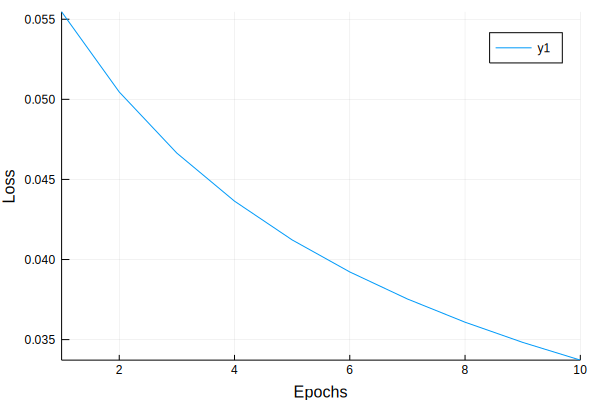

In [368]:
plot(losses,xlabel="Epochs",ylabel="Loss") 

In [369]:
idx = 16
imshow(w[1][:,:,1,1]);
imshow(x[:,:,1,idx]);
imshow(predict(w,x)[:,:,1,idx]);
imshow(y[:,:,1,idx]);

# Linear regression example with housing data

In [3]:
# Download the housing dataset from the UCI Machine Learning Repository
include(Pkg.dir("Knet","data","housing.jl"))
x,y = housing()
map(summary,(x,y))

INFO: Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data to /home/jon/.julia/v0.6/Knet/data/housing/housing.data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49082  100 49082    0     0  78749      0 --:--:-- --:--:-- --:--:-- 78657


("13×506 Array{Float64,2}", "1×506 Array{Float64,2}")

In [5]:
# Define loss
predict(w,x) = w[1]*x .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

In [6]:
# Initialize model
srand(42)
w = [ 0.1*rand(1,13), 0.0 ]

2-element Array{Any,1}:
  [0.0533183 0.0454029 … 0.0160006 0.0422956]
 0.0                                         

In [8]:
loss(w,x,y)

594.4352393887679

In [9]:
lossgradient(w,x,y)

2-element Array{Any,1}:
    [7.53003 -6.79923 … -6.369 13.8655]
 -45.0656                              

In [10]:
# Testing the gradient: Increasing w[2] by eps should decrease loss by 45.0656 * eps
w[2]=0.1

0.1

In [11]:
loss(w,x,y)

589.9386781239456

In [12]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train! (generic function with 1 method)

In [13]:
# Record the weights for 10 epochs
@time weights = [ copy(train!(w, [(x, y)])) for epoch=1:10 ]

  0.215568 seconds (440.65 k allocations: 17.270 MiB, 4.48% gc time)


10-element Array{Array{Any,1},1}:
 Any[[-0.699684 0.725326 … 0.652901 -1.34426], 4.58656]
 Any[[-0.551026 0.513913 … 0.565058 -1.53221], 8.17581]
 Any[[-0.59464 0.518516 … 0.634074 -1.88846], 11.0472] 
 Any[[-0.590579 0.487521 … 0.663802 -2.1303], 13.3443] 
 Any[[-0.594767 0.473771 … 0.698189 -2.33759], 15.182] 
 Any[[-0.596189 0.463224 … 0.727585 -2.50545], 16.6522]
 Any[[-0.598128 0.457414 … 0.754282 -2.64491], 17.8283]
 Any[[-0.600288 0.454846 … 0.777929 -2.7612], 18.7692] 
 Any[[-0.602933 0.455003 … 0.798796 -2.8591], 19.5219] 
 Any[[-0.606062 0.457353 … 0.817038 -2.94219], 20.1241]

In [14]:
losses = [ loss(w,x,y) for w in weights ]

10-element Array{Float64,1}:
 364.412 
 240.165 
 161.982 
 112.161 
  80.3404
  59.9844
  46.9397
  38.5626
  33.1684
  29.6825

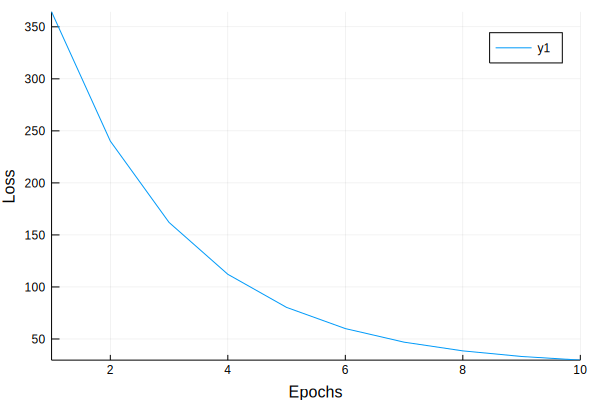

In [17]:
plot(losses,xlabel="Epochs",ylabel="Loss") 

# Load and minibatch MNIST data

In [18]:
include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

In [20]:
# dtrn and dtst are iterables of (x,y) minibatches, each minibatch contains 100 instances
length(dtrn),length(dtst)

(600, 100)

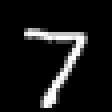

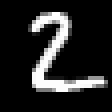

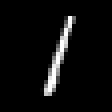

3-element Array{UInt8,1}:
 0x07
 0x02
 0x01

In [22]:
# Take a look at the first three test images and labels
(x,y) = first(dtst)
ax = Array(x)
for i=1:3; display(mnistview(ax,i)); end
y[1:3]

# Softmax classification example with MNIST

## Define softmax loss

In [27]:
# Define loss
predict(w,x) = w[1]*mat(x) .+ w[2]  # Same as linreg except we need mat() to convert input 4D->2D before matmul
loss(w,x,ygold) = nll(predict(w,x),ygold); # nll is negative log likelihood

In [28]:
# Initialize model
wsoft=map(Atype, [ 0.1*randn(10,784), zeros(10,1) ]);

In [30]:
# Average loss for a single (x,y) minibatch
loss(wsoft, x, y)

2.830448f0

In [31]:
# Average loss for the whole test set
nll(wsoft,dtst,predict)

2.8376572f0

In [32]:
# Accuracy for the whole test set
accuracy(wsoft,dtst,predict)

0.0407

## Train softmax model

In [33]:
@time softmodels = [ copy(train!(wsoft, dtrn)) for epoch=1:60 ];  # ~17 seconds

 27.146815 seconds (23.55 M allocations: 19.056 GiB, 6.95% gc time)


## Plot softmax learning curve

In [34]:
@time trnsoftloss = [ nll(w,dtrn,predict) for w in softmodels ];  # ~13 seconds
@time tstsoftloss = [ nll(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  7.467384 seconds (5.20 M allocations: 11.492 GiB, 13.65% gc time)
  1.332153 seconds (874.87 k allocations: 1.916 GiB, 13.19% gc time)


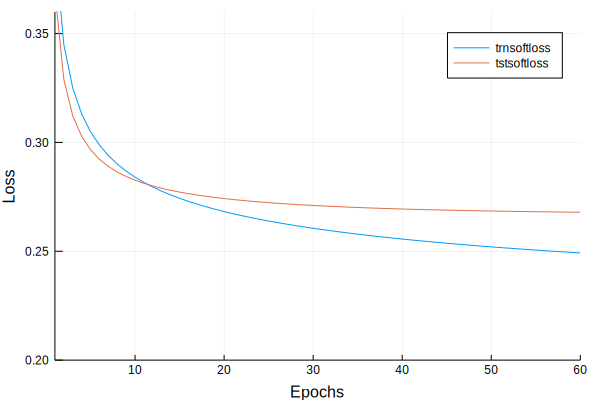

In [36]:
plot([trnsoftloss tstsoftloss],ylim=(.2,.36),labels=[:trnsoftloss :tstsoftloss],xlabel="Epochs",ylabel="Loss") 

## Plot softmax error rate

In [37]:
@time trnsofterr = [ 1-accuracy(w,dtrn,predict) for w in softmodels ];  # ~12 seconds
@time tstsofterr = [ 1-accuracy(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  6.153225 seconds (3.33 M allocations: 11.134 GiB, 15.74% gc time)
  1.062067 seconds (562.73 k allocations: 1.856 GiB, 15.49% gc time)


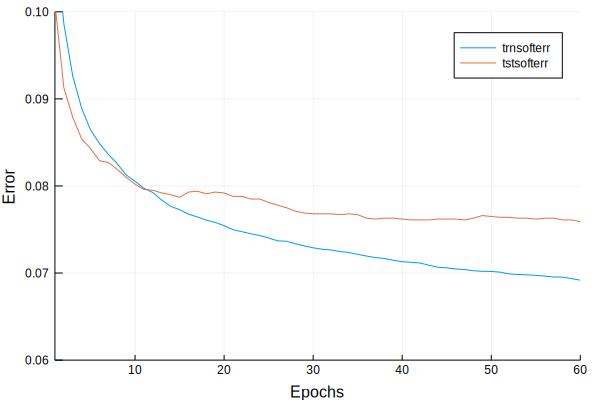

In [39]:
plot([trnsofterr tstsofterr],ylim=(.06,.10),labels=[:trnsofterr :tstsofterr],xlabel="Epochs",ylabel="Error")

In [40]:
# Cleanup
wsoft = softmodels = nothing; knetgc()

# Multilayer perceptron example with MNIST

In [41]:
# We only need to change the predict function!
function predict(w,x)
    for i=1:2:length(w)
        x = w[i]*mat(x) .+ w[i+1]
        if i<length(w)-1
            x = max.(0,x)                         
        end
    end
    return x
end

predict (generic function with 1 method)

In [43]:
wmlp=map(Atype, [ 0.1*randn(64,784), zeros(64,1), 
                  0.1*randn(10,64),  zeros(10,1) ])
loss(wmlp, x, y)  # average loss for random model should be close to log(10)=2.3026

2.4366724f0

## Train MLP model

In [44]:
@time mlpmodels = [ copy(train!(wmlp, dtrn)) for epoch=1:60 ]; # ~20 seconds

 60.059827 seconds (39.31 M allocations: 58.845 GiB, 9.66% gc time)


## Compare MLP loss with softmax loss

In [45]:
@time trnmlploss = [ nll(w,dtrn,predict) for w in mlpmodels ]; # ~12 seconds
@time tstmlploss = [ nll(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 13.244330 seconds (7.18 M allocations: 14.151 GiB, 10.61% gc time)
  2.302616 seconds (1.20 M allocations: 2.359 GiB, 10.41% gc time)


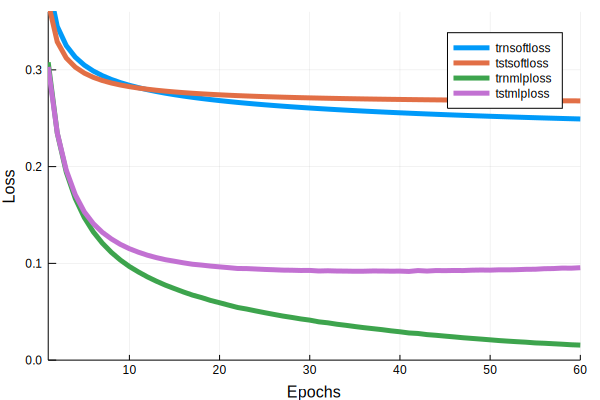

In [50]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss],
    xlabel="Epochs",ylabel="Loss",linewidth=5,ylim=(.0,.36),
    labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss]) 

## Compare MLP error with softmax error

In [51]:
@time trnmlperr = [ 1-accuracy(w,dtrn,predict) for w in mlpmodels ]; # ~13 seconds
@time tstmlperr = [ 1-accuracy(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 10.386532 seconds (5.31 M allocations: 13.793 GiB, 12.48% gc time)
  1.744261 seconds (892.73 k allocations: 2.299 GiB, 12.66% gc time)


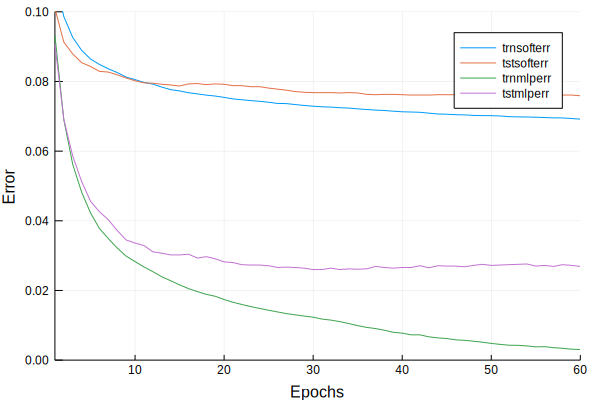

In [53]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr],xlabel="Epochs",ylabel="Error")

In [54]:
# Cleanup
wmlp = mlpmodels = nothing; knetgc()

# CNN example with MNIST (The LeNet model)

In [55]:
# We only need to change the predict function!
function predict(w,x) # LeNet model
    n=length(w)-4
    for i=1:2:n
        x = pool(relu.(conv4(w[i],x) .+ w[i+1]))
    end
    for i=n+1:2:length(w)-2
        x = relu.(w[i]*mat(x) .+ w[i+1])
    end
    return w[end-1]*x .+ w[end]
end

predict (generic function with 1 method)

In [57]:
wcnn=map(Atype, [ 0.1*randn(5,5,1,20),  zeros(1,1,20,1), 
                  0.1*randn(5,5,20,50), zeros(1,1,50,1),
                  0.1*randn(500,800),  zeros(500,1),
                  0.1*randn(10,500),  zeros(10,1) ])
loss(wcnn, x, y)

4.1054115f0

## Train CNN model

In [ ]:
@time cnnmodels = [ copy(train!(wcnn, dtrn)) for epoch=1:60 ]; # ~127 seconds

## Compare CNN loss with MLP

In [ ]:
@time trncnnloss = [ nll(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnloss = [ nll(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

In [ ]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss trncnnloss tstcnnloss],ylim=(.0,.36),labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss :trncnnloss :tstcnnloss],xlabel="Epochs",ylabel="Loss") 

## Compare CNN error with MLP

In [ ]:
@time trncnnerr = [ 1-accuracy(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnerr = [ 1-accuracy(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

In [ ]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr trncnnerr tstcnnerr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr :trncnnerr :tstcnnerr],xlabel="Epochs",ylabel="Error")

In [42]:
# Cleanup
wcnn = cnnmodels = nothing; knetgc()

# Shakespeare example

In [43]:
# Please see charlm.ipynb for training a character based language model on "The Complete Works of William Shakespeare"

# VGG example

In [44]:
include(Knet.dir("examples/vgg/vgg.jl"));

In [ ]:
caturl = "https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg"
catfile = download(caturl)
load(catfile)

In [47]:
VGG.main(catfile)

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "/dev/shm/dyuret/.julia/v0.6/Knet/data/cat.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Loading imagenet-vgg-verydeep-16.mat...


5×2 Array{Any,2}:
 0.27327    "tabby, tabby cat"        
 0.253185   "Egyptian cat"            
 0.248429   "tiger cat"               
 0.060727   "kit fox, Vulpes macrotis"
 0.0561707  "red fox, Vulpes vulpes"  

  5.173264 seconds (61.56 k allocations: 3.428 MiB, 81.30% gc time)


INFO: Classifying


In [48]:
VGG.main("https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Downloading https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13411  100 13411    0     0   6702      0  0:00:02  0:00:02 --:--:--  6705
INFO: Classifying


5×2 Array{Any,2}:
 0.899679    "garbage truck, dustcart"                                                   
 0.0654105   "moving van"                                                                
 0.0201083   "crane"                                                                     
 0.00583589  "trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi"
 0.00515393  "snowplow, snowplough"                                                      

  0.039080 seconds (1.85 k allocations: 90.297 KiB)

